In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
==============================================
EfficientNet 웹툰 분류 - 1단계 (기본 학습)
==============================================
이 코드를 먼저 실행하세요!
출력: webtoon_efficientnet_b3_stage1.pt
==============================================
"""

import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import timm

print("=" * 50)
print("1단계: EfficientNet-B3 기본 학습 시작")
print("=" * 50)

# ================================
# 1️⃣ 기본 설정
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
OUTPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage1.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ================================
# 2️⃣ Dataset 정의
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for work_id in os.listdir(root_dir):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue
            for bundle in os.listdir(work_path):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue
                for fname in os.listdir(bundle_path):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))
        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = self.class_to_idx[label]
        return img, label_idx

# ================================
# 3️⃣ Transform
# ================================
transform_train = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomResizedCrop(320, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# ================================
# 4️⃣ Dataset 및 DataLoader
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=transform_train)

total = len(full_dataset)
indices = list(range(total))
random.shuffle(indices)

test_size = int(0.2 * total)
val_size = int(0.2 * total)
train_size = total - test_size - val_size

train_dataset = Subset(full_dataset, indices[:train_size])
val_dataset = Subset(full_dataset, indices[train_size:train_size + val_size])
test_dataset = Subset(full_dataset, indices[train_size + val_size:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Train batches: {len(train_loader)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}, Classes: {num_classes}")

# ================================
# 5️⃣ 모델 정의 (EfficientNet-B3 + Gradual Unfreeze)
# ================================
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
# Dropout 추가
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ================================
# 6️⃣ 학습 루프
# ================================
best_acc = 0.0
EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    # Gradual unfreeze
    if epoch == 1:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif epoch == 5:
        for name, param in model.named_parameters():
            if "blocks.6" in name or "blocks.5" in name or "classifier" in name:
                param.requires_grad = True
    elif epoch == 10:
        for param in model.parameters():
            param.requires_grad = True

    # ---- Training ----
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    val_loss /= total

    print(f"Epoch [{epoch}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"✅ Best model saved at epoch {epoch} (Val Acc: {val_acc*100:.2f}%)")

# ================================
# 7️⃣ 테스트
# ================================
model.load_state_dict(torch.load(OUTPUT_MODEL_PATH))
model.eval()

test_correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = test_correct / total
print(f"\n🎯 1단계 완료! Test Accuracy: {test_acc*100:.2f}%")
print(f"📦 모델 저장 위치: {OUTPUT_MODEL_PATH}")
print("\n✅ 1단계 완료! 이제 2단계 코드를 실행하세요!")

1단계: EfficientNet-B3 기본 학습 시작
Device: cuda
Train batches: 523
Train: 16722, Val: 5574, Test: 5574, Classes: 340
Epoch [1/20] | Train Loss: 5.7000 | Train Acc: 1.23% | Val Loss: 5.5982 | Val Acc: 1.65%
✅ Best model saved at epoch 1 (Val Acc: 1.65%)
Epoch [2/20] | Train Loss: 5.4977 | Train Acc: 2.09% | Val Loss: 5.4668 | Val Acc: 3.21%
✅ Best model saved at epoch 2 (Val Acc: 3.21%)
Epoch [3/20] | Train Loss: 5.3486 | Train Acc: 4.51% | Val Loss: 5.3598 | Val Acc: 4.59%
✅ Best model saved at epoch 3 (Val Acc: 4.59%)
Epoch [4/20] | Train Loss: 5.2182 | Train Acc: 6.80% | Val Loss: 5.2568 | Val Acc: 7.14%
✅ Best model saved at epoch 4 (Val Acc: 7.14%)
Epoch [5/20] | Train Loss: 4.4229 | Train Acc: 15.73% | Val Loss: 4.0061 | Val Acc: 20.72%
✅ Best model saved at epoch 5 (Val Acc: 20.72%)
Epoch [6/20] | Train Loss: 3.5359 | Train Acc: 28.15% | Val Loss: 3.4349 | Val Acc: 28.70%
✅ Best model saved at epoch 6 (Val Acc: 28.70%)
Epoch [7/20] | Train Loss: 2.9438 | Train Acc: 38.69% | Val Loss: 

In [ ]:
"""
==============================================
EfficientNet 웹툰 분류 - 2단계 (고급 학습)
==============================================
⚠️ 반드시 1단계 모델이 존재해야 합니다!
입력: webtoon_efficientnet_b3_stage1.pt
출력: webtoon_efficientnet_b3_stage2.pt
==============================================
"""

import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import timm

print("=" * 50)
print("2단계: EfficientNet-B3 고급 학습 시작")
print("=" * 50)

# ================================
# 기본 설정
# ================================
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
INPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage1.pt"
OUTPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage2.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ================================
# Dataset 정의
# ================================
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        for work_id in os.listdir(root_dir):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue

            for bundle in os.listdir(work_path):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue

                for fname in os.listdir(bundle_path):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))

        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]

# ================================
# 2단계용 Augmentation (강화)
# ================================
transform_train = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.RandomResizedCrop(384, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.1)], p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# ================================
# Dataset & DataLoader
# ================================
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=transform_train)

total = len(full_dataset)
indices = list(range(total))
random.shuffle(indices)

test_size = int(0.2 * total)
val_size = int(0.2 * total)
train_size = total - val_size - test_size

train_dataset = Subset(full_dataset, indices[:train_size])
val_dataset = Subset(full_dataset, indices[train_size:train_size+val_size])
test_dataset = Subset(full_dataset, indices[train_size+val_size:])

val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}, Classes: {num_classes}")

# ================================
# 1단계 모델 구조 완전히 동일하게 복원
# ================================
model = timm.create_model('efficientnet_b3', pretrained=False, num_classes=num_classes)

# 1단계와 동일한 classifier 구조
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)
)

# 1단계 weight 로드
checkpoint = torch.load(INPUT_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=True)

model = model.to(device)

# ================================
# 2단계 Optimizer & Loss
# — LR 살짝 낮춤
# ================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# ================================
# 2단계: Layer Unfreeze (backbone 일부 학습)
# ================================
for name, param in model.named_parameters():
    if "blocks.6" in name or "blocks.5" in name:
        param.requires_grad = True
    elif "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # backbone 상위는 얼림

# ================================
# Train Loop
# ================================
best_acc = 0.0
EPOCHS = 15

for epoch in range(1, EPOCHS + 1):
    model.train()

    train_loss, train_correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # Validation
    model.eval()
    val_loss, val_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    val_loss /= total

    print(f"Epoch [{epoch}/{EPOCHS}] | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    # Save best
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"✅ Best model updated at epoch {epoch} (Val Acc: {val_acc*100:.2f}%)")

# ================================
# Test
# ================================
model.load_state_dict(torch.load(OUTPUT_MODEL_PATH))
model.eval()

test_correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = test_correct / total
print(f"\n🎯 2단계 완료! Test Accuracy: {test_acc*100:.2f}%")
print(f"📦 저장 위치: {OUTPUT_MODEL_PATH}")

print("\n📢 3단계(Fine-tuning)로 넘어갈 준비 완료!")


2단계: EfficientNet-B3 고급 학습 시작
Device: cuda
Train: 16722, Val: 5574, Test: 5574, Classes: 340
Epoch [1/15] | Train Acc: 99.26% | Val Acc: 58.93%
✅ Best model updated at epoch 1 (Val Acc: 58.93%)
Epoch [2/15] | Train Acc: 99.81% | Val Acc: 59.44%
✅ Best model updated at epoch 2 (Val Acc: 59.44%)
Epoch [3/15] | Train Acc: 99.92% | Val Acc: 59.92%
✅ Best model updated at epoch 3 (Val Acc: 59.92%)
Epoch [4/15] | Train Acc: 99.93% | Val Acc: 60.67%
✅ Best model updated at epoch 4 (Val Acc: 60.67%)
Epoch [5/15] | Train Acc: 99.99% | Val Acc: 60.48%
Epoch [6/15] | Train Acc: 99.99% | Val Acc: 60.41%
Epoch [7/15] | Train Acc: 99.99% | Val Acc: 60.58%
Epoch [8/15] | Train Acc: 99.95% | Val Acc: 59.89%
Epoch [9/15] | Train Acc: 99.98% | Val Acc: 59.94%
Epoch [10/15] | Train Acc: 99.98% | Val Acc: 60.42%
Epoch [11/15] | Train Acc: 99.99% | Val Acc: 60.28%
Epoch [12/15] | Train Acc: 99.99% | Val Acc: 60.75%
✅ Best model updated at epoch 12 (Val Acc: 60.75%)
Epoch [13/15] | Train Acc: 99.98% | Val A

In [ ]:
"""
==============================================
EfficientNet 웹툰 분류 - 3단계 (Final Fine-tuning)
==============================================
입력 체크포인트: webtoon_efficientnet_b3_stage2.pt
출력 체크포인트: webtoon_efficientnet_b3_stage3.pt
설명: Stage2 가중치를 불러와 classifier dropout을 in-place로 늘리고
전체 파라미터를 unfreeze하여 아주 낮은 LR로 미세조정합니다.
==============================================
"""

import os
import random
import numpy as np
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import timm

# -------------------------
# Config
# -------------------------
NAVER_ROOT_DIR = "/content/drive/MyDrive/Naver_Processed"
INPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage2.pt"
OUTPUT_MODEL_PATH = "/content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 24            # GPU 메모리에 맞춰 조정 가능
NUM_WORKERS = 2            # Colab 권장 값(너가 이전에 2로 실행했음)
EPOCHS = 12
LR = 3e-5
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.2
EARLY_STOPPING_PATIENCE = 5

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Device:", DEVICE)

# -------------------------
# Dataset (same as before)
# -------------------------
class WebtoonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for work_id in sorted(os.listdir(root_dir)):
            work_path = os.path.join(root_dir, work_id)
            if not os.path.isdir(work_path):
                continue
            for bundle in sorted(os.listdir(work_path)):
                bundle_path = os.path.join(work_path, bundle)
                if not os.path.isdir(bundle_path):
                    continue
                for fname in sorted(os.listdir(bundle_path)):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                        self.samples.append((os.path.join(bundle_path, fname), work_id))
        self.classes = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]

# -------------------------
# Transforms (strong but stable)
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomResizedCrop(384, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.05)], p=0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),
    transforms.RandAugment(),              # 강화 포인트
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# -------------------------
# Build datasets + loaders (same split as before)
# -------------------------
full_dataset = WebtoonDataset(NAVER_ROOT_DIR, transform=train_transform)
total = len(full_dataset)
print("Total images:", total)

indices = list(range(total))
random.shuffle(indices)

test_size = int(0.2 * total)
val_size = int(0.2 * total)
train_size = total - test_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform=val_transform), val_idx)
test_dataset = Subset(WebtoonDataset(NAVER_ROOT_DIR, transform=val_transform), test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES = len(full_dataset.classes)
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}, Classes={NUM_CLASSES}")

# -------------------------
# Model: create then load Stage2 weights
# Make sure classifier structure matches Stage1/2 (Sequential(Dropout, Linear))
# -------------------------
model = timm.create_model('efficientnet_b3', pretrained=False, num_classes=NUM_CLASSES)
in_features = model.classifier.in_features
# ensure same structure (stage1 & stage2 used Dropout(0.4) here)
model.classifier = nn.Sequential(nn.Dropout(0.4), nn.Linear(in_features, NUM_CLASSES))

# load stage2 weights
if not os.path.exists(INPUT_MODEL_PATH):
    raise FileNotFoundError(f"Stage2 checkpoint not found: {INPUT_MODEL_PATH}")
checkpoint = torch.load(INPUT_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint, strict=True)
print("✅ Loaded Stage2 weights")

# now we want stronger dropout (0.5) but keep linear weights — change in-place:
if isinstance(model.classifier, nn.Sequential) and isinstance(model.classifier[0], nn.Dropout):
    model.classifier[0].p = 0.5
    print(f"✅ In-place updated classifier dropout -> {model.classifier[0].p}")

model = model.to(DEVICE)

# -------------------------
# Unfreeze all params for final fine-tune
# -------------------------
for p in model.parameters():
    p.requires_grad = True

# -------------------------
# Loss / Optimizer / Scheduler
# -------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

# -------------------------
# Early stopping util
# -------------------------
best_val = 0.0
best_epoch = 0
no_improve = 0

# -------------------------
# Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # Validation
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    scheduler.step()

    epoch_time = time.time() - t0
    print(f"Epoch [{epoch}/{EPOCHS}] | time: {epoch_time:.1f}s | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best
    if val_acc > best_val + 1e-6:
        best_val = val_acc
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
        print(f"🔥 New best model saved (epoch {epoch}, Val Acc: {val_acc*100:.2f}%) -> {OUTPUT_MODEL_PATH}")
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"⛔ Early stopping (no improvement for {EARLY_STOPPING_PATIENCE} epochs).")
        break

# -------------------------
# Load best and final test
# -------------------------
if os.path.exists(OUTPUT_MODEL_PATH):
    model.load_state_dict(torch.load(OUTPUT_MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()

    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    final_test_acc = test_correct / test_total
    print(f"\n🎯 Stage3 finished. Best Val Acc: {best_val*100:.2f}% (epoch {best_epoch})")
    print(f"🎯 Final Test Accuracy: {final_test_acc*100:.2f}%")
    print(f"📦 Stage3 checkpoint: {OUTPUT_MODEL_PATH}")
else:
    print("⚠️ No best model saved during training.")


Device: cuda
Total images: 27870
Train=16722, Val=5574, Test=5574, Classes=340
✅ Loaded Stage2 weights
✅ In-place updated classifier dropout -> 0.5
Epoch [1/12] | time: 677.8s | Train Loss: 3.6477 | Train Acc: 64.11% | Val Loss: 2.6317 | Val Acc: 81.25%
🔥 New best model saved (epoch 1, Val Acc: 81.25%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [2/12] | time: 623.3s | Train Loss: 2.9451 | Train Acc: 70.76% | Val Loss: 2.5471 | Val Acc: 82.94%
🔥 New best model saved (epoch 2, Val Acc: 82.94%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [3/12] | time: 634.4s | Train Loss: 2.8230 | Train Acc: 74.26% | Val Loss: 2.5315 | Val Acc: 83.15%
🔥 New best model saved (epoch 3, Val Acc: 83.15%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [4/12] | time: 633.6s | Train Loss: 2.7365 | Train Acc: 76.81% | Val Loss: 2.4937 | Val Acc: 83.57%
🔥 New best model saved (epoch 4, Val Acc: 83.57%) -> 

✔ Parsed 12 epochs


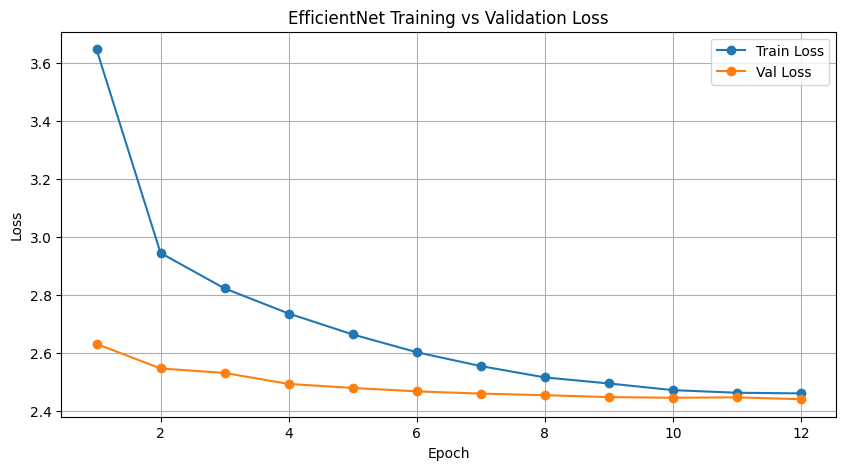

📁 Loss curve saved → /content/drive/MyDrive/Webtoon_Models/efficientnet_loss_curve.png


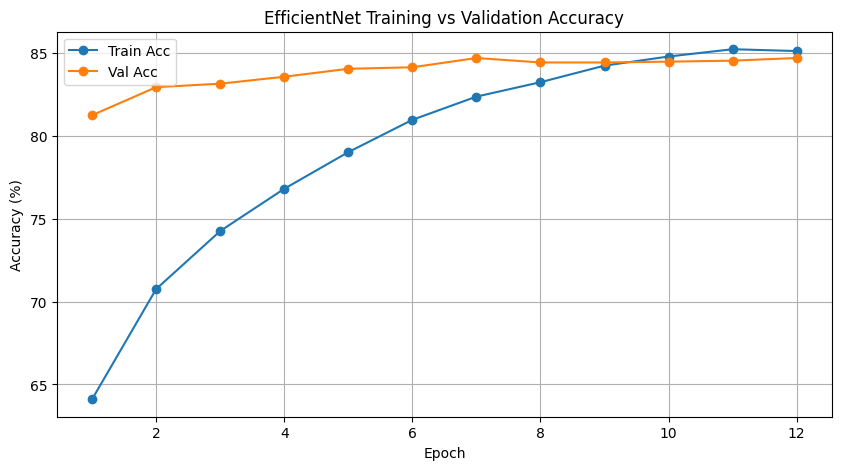

📁 Accuracy curve saved → /content/drive/MyDrive/Webtoon_Models/efficientnet_accuracy_curve.png


In [2]:
import re
import matplotlib.pyplot as plt
import os

SAVE_DIR = "/content/drive/MyDrive/Webtoon_Models/"
os.makedirs(SAVE_DIR, exist_ok=True)

# ====================================================================
# ✏️ 여기에 EfficientNet Stage2 또는 Stage3 전체 로그를 붙여넣으면 됨
# ====================================================================
log_text = """
Epoch [1/12] | time: 5056.5s | Train Loss: 3.6477 | Train Acc: 64.11% | Val Loss: 2.6317 | Val Acc: 81.25%
🔥 New best model saved (epoch 1, Val Acc: 81.25%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [2/12] | time: 697.6s | Train Loss: 2.9451 | Train Acc: 70.76% | Val Loss: 2.5471 | Val Acc: 82.94%
🔥 New best model saved (epoch 2, Val Acc: 82.94%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [3/12] | time: 630.8s | Train Loss: 2.8230 | Train Acc: 74.26% | Val Loss: 2.5315 | Val Acc: 83.15%
🔥 New best model saved (epoch 3, Val Acc: 83.15%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [4/12] | time: 641.8s | Train Loss: 2.7365 | Train Acc: 76.81% | Val Loss: 2.4937 | Val Acc: 83.57%
🔥 New best model saved (epoch 4, Val Acc: 83.57%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [5/12] | time: 642.6s | Train Loss: 2.6643 | Train Acc: 79.02% | Val Loss: 2.4799 | Val Acc: 84.05%
🔥 New best model saved (epoch 5, Val Acc: 84.05%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [6/12] | time: 635.6s | Train Loss: 2.6030 | Train Acc: 80.97% | Val Loss: 2.4681 | Val Acc: 84.14%
🔥 New best model saved (epoch 6, Val Acc: 84.14%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [7/12] | time: 630.1s | Train Loss: 2.5552 | Train Acc: 82.37% | Val Loss: 2.4604 | Val Acc: 84.70%
🔥 New best model saved (epoch 7, Val Acc: 84.70%) -> /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
Epoch [8/12] | time: 676.4s | Train Loss: 2.5162 | Train Acc: 83.24% | Val Loss: 2.4548 | Val Acc: 84.43%
Epoch [9/12] | time: 615.7s | Train Loss: 2.4953 | Train Acc: 84.24% | Val Loss: 2.4484 | Val Acc: 84.43%
Epoch [10/12] | time: 622.3s | Train Loss: 2.4723 | Train Acc: 84.79% | Val Loss: 2.4460 | Val Acc: 84.48%
Epoch [11/12] | time: 631.8s | Train Loss: 2.4633 | Train Acc: 85.23% | Val Loss: 2.4474 | Val Acc: 84.54%
Epoch [12/12] | time: 666.1s | Train Loss: 2.4611 | Train Acc: 85.12% | Val Loss: 2.4410 | Val Acc: 84.70%
⛔ Early stopping (no improvement for 5 epochs).

🎯 Stage3 finished. Best Val Acc: 84.70% (epoch 7)
🎯 Final Test Accuracy: 84.86%
📦 Stage3 checkpoint: /content/drive/MyDrive/Webtoon_Models/webtoon_efficientnet_b3_stage3.pt
"""

# ====================================================================
# 🔍 EfficientNet 로그 정규식 패턴 (ResNet과 완전히 동일 구조)
# ====================================================================
pattern = r"Epoch\s*\[(\d+)/\d+\]\s*\|.*?Train Loss:\s*([\d\.]+)\s*\|\s*Train Acc:\s*([\d\.]+)%\s*\|\s*Val Loss:\s*([\d\.]+)\s*\|\s*Val Acc:\s*([\d\.]+)%"

matches = re.findall(pattern, log_text, flags=re.DOTALL)

epochs = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for m in matches:
    epoch = int(m[0])
    train_loss = float(m[1])
    train_acc = float(m[2])
    val_loss = float(m[3])
    val_acc = float(m[4])

    epochs.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

print(f"✔ Parsed {len(epochs)} epochs")

# ====================================================================
# 📊 Loss Curve
# ====================================================================
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title("EfficientNet Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

loss_path = os.path.join(SAVE_DIR, "efficientnet_loss_curve.png")
plt.savefig(loss_path, dpi=300)
plt.show()
print(f"📁 Loss curve saved → {loss_path}")

# ====================================================================
# 📈 Accuracy Curve
# ====================================================================
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='o', label='Val Acc')
plt.title("EfficientNet Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

acc_path = os.path.join(SAVE_DIR, "efficientnet_accuracy_curve.png")
plt.savefig(acc_path, dpi=300)
plt.show()
print(f"📁 Accuracy curve saved → {acc_path}")
